In [ ]:
# default_exp makers

# neos.makers

> Functions that define the workflow from parametric observable --> statistical model.

This module contains example implementations of functions that are composed such that everything downstream is a function of the parameters of your observable, e.g. the weights of a neural network.

A key idea here is that the functions in this module take in and return functions, such that one can compose them for an end result like:
`loss = cls_maker(model_maker(hist_maker)) --> loss(params) = CLs`, as we want to compose our workflow such that the end result is explicitly a function of the parameters of the observable.

In [ ]:
#export
import jax
import jax.scipy as jsc
import jax.numpy as jnp
import numpy as np
from functools import partial

from neos import models

## Histogram makers:

In [ ]:
#export
def hists_from_nn_three_blobs(predict, NMC = 500, sig_mean = [-1, 1], b1_mean=[2, 2], b2_mean=[-1, -1], LUMI=10, sig_scale = 2, bkg_scale = 10):
    '''
    Uses the nn decision function `predict` to form histograms from signal and background 
    data, all drawn from multivariate normal distributions with different means. Two 
    background distributions are sampled from, which is meant to mimic the situation in 
    particle physics where one has a 'nominal' prediction for a nuisance parameter and then 
    an alternate value (e.g. from varying up/down by one standard deviation), which then 
    modifies the background pdf. Here, we take that effect to be a shift of the mean of the 
    distribution. The value for the background histogram is then the mean of the resulting 
    counts of the two modes, and the uncertainty can be quantified through the count 
    standard deviation.
    
    Args:
            predict: Decision function for a parameterized observable. Assumed softmax here.

    Returns:
            hist_maker: A callable function that takes the parameters of the observable, 
            then constructs signal, background, and background uncertainty yields.
    '''
    def get_hists(network, s, bs):
        NMC = len(s)
        s_hist = predict(network, s).sum(axis=0) * sig_scale / NMC * LUMI
        
        b_hists = tuple(
            (predict(network, b).sum(axis=0) * bkg_scale / NMC * LUMI) for b in bs
        )
        
        b_mean = jax.numpy.mean(jax.numpy.asarray(b_hists), axis=0)
        b_unc = jax.numpy.std(jax.numpy.asarray(b_hists), axis=0)
        results = s_hist, b_mean, b_unc
        return results


    def hist_maker():
        bkg1 = np.random.multivariate_normal(b1_mean, [[1, 0], [0, 1]], size=(NMC,))
        bkg2 = np.random.multivariate_normal(b2_mean, [[1, 0], [0, 1]], size=(NMC,))
        sig = np.random.multivariate_normal(sig_mean, [[1, 0], [0, 1]], size=(NMC,))

        def make(network):
            return get_hists(network, sig, (bkg1,bkg2))

        make.bkg1 = bkg1
        make.bkg2 = bkg2
        make.sig = sig
        return make
    
    return hist_maker



### Example usage for `hists_from_nn_three_blobs`:

In [ ]:
from jax.experimental import stax

init_random_params, predict = stax.serial(
    stax.Dense(100),
    stax.Relu,
    stax.Dense(2), # Two node output -> two bins!
    stax.Softmax,
)

hist_maker = hists_from_nn_three_blobs(predict)

We would then compose `hist_maker` with other functions that define a model and a way to do statistical inference, but we can still use it standalone if we want:

In [ ]:
# initialize network parameters
_, network = init_random_params(jax.random.PRNGKey(2), (-1, 2))

hists_from_network = hist_maker()
s, b, b_unc = hists_from_network(network)
print(s, b, b_unc)

[10.38028255  9.61971745] [45.45590118 54.54409882] [7.6892415 7.6892415]


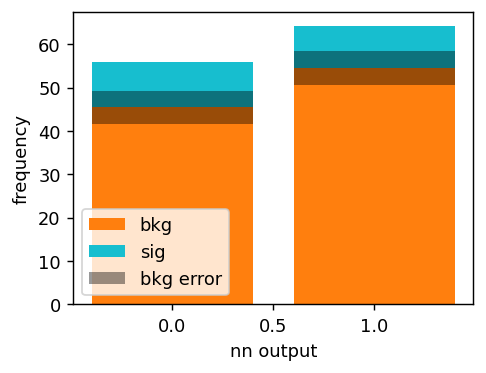

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3),dpi=129)
plt.bar([0, 1], b, color="C1", label="bkg")
plt.bar([0, 1], s, bottom=b, color="C9", label="sig")
plt.bar([0, 1], b_unc, bottom=b - b_unc / 2.0, alpha=0.4, color="black", label="bkg error")
plt.xlabel('nn output')
plt.ylabel('frequency')
plt.legend()

## Using kernel density estimation:

Watch the kernel density estimate mimic a histogram using discrete evaluations of the integral of the cumulative density function:

![](assets/kde_bins.giF)

In [ ]:
#export
# kde experiment

def kde_bins_from_nn_three_blobs(predict, bins, bandwidth, NMC = 500, sig_mean = [-1, 1], b1_mean=[2, 2], b2_mean=[-1, -1], LUMI=10, sig_scale = 2, bkg_scale = 10):
    '''
    Exactly the same as `hists_from_nn_three_blobs`, but takes in a regression network, and
    forms a kernel density estimate (kde) for the output. The yields are then calculated as 
    the integral of the kde's cumulative density function between the bin edges, which should
    be specified using the argument `bins`.
    
    Args:
            predict: Decision function for a parameterized observable. When evaluated, the 
            output should be one number per event, i.e. a regression network or similar.
            
            bins: Array of bin edges, e.g. np.linspace(0,1,3) defines a two-bin histogram with
            edges at 0, 0.5, 1.
            
            bandwidth: Float that controls the 'smoothness' of the kde. It's recommended to keep
            this lower than the bin width to avoid oversmoothing the distribution. Going too low
            will cause things to break, as the gradients of the kde become unstable. 0.1*bin_width
            is a good rule of thumb, but we have yet to properly validate this practically.

    Returns:
            hist_maker: A callable function that takes the parameters of the observable, 
            then constructs signal, background, and background uncertainty yields.
    '''
    # grab bin edges
    edge_lo   = bins[:-1]
    edge_hi   = bins[1:]
    
    # get counts from gaussian cdfs centered on each event, evaluated binwise
    def to_hist(events):
        cdf_up = jsc.stats.norm.cdf(edge_hi.reshape(-1,1),loc = events, scale = bandwidth)
        cdf_dn = jsc.stats.norm.cdf(edge_lo.reshape(-1,1),loc = events, scale = bandwidth)
        summed = (cdf_up-cdf_dn).sum(axis=1)
        return summed
    
    def get_hists(network, s, b1, b2):
        NMC = len(s)
        nn_s, nn_b1, nn_b2 = (
            predict(network, s).ravel(),
            predict(network, b1).ravel(),
            predict(network, b2).ravel(),
        )
             
        kde_counts = jax.numpy.asarray([
            to_hist(nn_s)* sig_scale / NMC * LUMI,
            to_hist(nn_b1)* bkg_scale / NMC * LUMI,
            to_hist(nn_b2)* bkg_scale / NMC * LUMI,
        ])
        
        b_mean = jax.numpy.mean(kde_counts[1:], axis=0)
        b_unc = jax.numpy.std(kde_counts[1:], axis=0)
        results = kde_counts[0], b_mean,b_unc
        return results


    def hist_maker():
        bkg1 = np.random.multivariate_normal(b1_mean, [[1, 0], [0, 1]], size=(NMC,))
        bkg2 = np.random.multivariate_normal(b2_mean, [[1, 0], [0, 1]], size=(NMC,))
        sig = np.random.multivariate_normal(sig_mean, [[1, 0], [0, 1]], size=(NMC,))

        def make(network):
            return get_hists(network, sig, bkg1, bkg2)

        make.bkg1 = bkg1
        make.bkg2 = bkg2
        make.sig = sig
        return make
    
    return hist_maker

### Example usage for `kde_bins_from_nn_three_blobs`:

In [ ]:
init_random_params, predict = stax.serial(
    stax.Dense(100),
    stax.Relu,
    stax.Dense(1), # One node for regression
    stax.Sigmoid,
)

# need to pre-specify binning: use 0-1 range from sigmoid
# NB: should work with relu etc too, just have to make a binning choice
bins = np.linspace(0,1,4)
centers   = bins[:-1]  + np.diff(bins)/2. # for plotting

# pick a bandwidth
bin_width = 1/(len(bins)-1)
bandwidth = 0.5 * bin_width

hist_maker = kde_bins_from_nn_three_blobs(predict, bins, bandwidth)

As before, we can use this stand-alone if desired:

In [ ]:
# initialize network parameters
_, network = init_random_params(jax.random.PRNGKey(2), (-1, 2))

hists_from_network = hist_maker()
s, b, b_unc = hists_from_network(network)
print(s, b, b_unc)

[ 6.17462559 12.07716788  1.55236726] [21.62991409 63.26108926 14.43074986] [10.44450875  3.20164352  7.54310471]


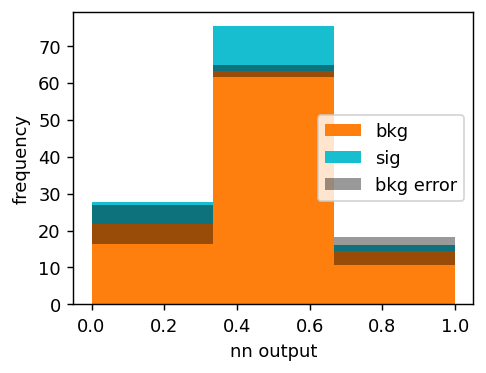

In [ ]:
plt.figure(figsize=(4,3),dpi=129)
plt.bar(centers, b, color="C1", label="bkg",width=bin_width)
plt.bar(centers, s, bottom=b, color="C9", label="sig",width=bin_width)
plt.bar(centers, b_unc, bottom=b - b_unc / 2.0, alpha=0.4, color="black", label="bkg error",width=bin_width)
plt.xlabel('nn output')
plt.ylabel('frequency')
plt.legend()

In [ ]:
#export
# kde experiment

def kde_bins_from_nn_histosys(predict, bins, bandwidth, NMC = 500, sig_mean = [-1, 1], b1_mean=[2.5, 2], b_mean=[1, -1], b2_mean=[-2.5, -1.5], LUMI=10, sig_scale = 2, bkg_scale = 10):
    '''
    Exactly the same as `hists_from_nn_three_blobs`, but takes in a regression network, and
    forms a kernel density estimate (kde) for the output. The yields are then calculated as 
    the integral of the kde's cumulative density function between the bin edges, which should
    be specified using the argument `bins`.
    
    Args:
            predict: Decision function for a parameterized observable. When evaluated, the 
            output should be one number per event, i.e. a regression network or similar.
            
            bins: Array of bin edges, e.g. np.linspace(0,1,3) defines a two-bin histogram with
            edges at 0, 0.5, 1.
            
            bandwidth: Float that controls the 'smoothness' of the kde. It's recommended to keep
            this lower than the bin width to avoid oversmoothing the distribution. Going too low
            will cause things to break, as the gradients of the kde become unstable. 0.1*bin_width
            is a good rule of thumb, but we have yet to properly validate this practically.

    Returns:
            hist_maker: A callable function that takes the parameters of the observable, 
            then constructs signal, background, and background uncertainty yields.
    '''
    # grab bin edges
    edge_lo   = bins[:-1]
    edge_hi   = bins[1:]
    
    # get counts from gaussian cdfs centered on each event, evaluated binwise
    def to_hist(events):
        cdf_up = jsc.stats.norm.cdf(edge_hi.reshape(-1,1),loc = events, scale = bandwidth)
        cdf_dn = jsc.stats.norm.cdf(edge_lo.reshape(-1,1),loc = events, scale = bandwidth)
        summed = (cdf_up-cdf_dn).sum(axis=1)
        return summed
    
    def get_hists(network, s, b_nom, b_up, b_down):
        NMC = len(s)
        nn_s, nn_b_nom, nn_b_up, nn_b_down = (
            predict(network, s).ravel(),
            predict(network, b_nom).ravel(),
            predict(network, b_up).ravel(),
            predict(network, b_down).ravel(),
        )
             
        kde_counts = jax.numpy.asarray([
            to_hist(nn_s) * sig_scale / NMC * LUMI,
            to_hist(nn_b_nom) * bkg_scale / NMC * LUMI,
            to_hist(nn_b_up) * bkg_scale / NMC * LUMI,
            to_hist(nn_b_down) * bkg_scale / NMC * LUMI,
        ])
        
        return kde_counts


    def hist_maker():
        bkg_up = np.random.multivariate_normal(b1_mean, [[1, 0], [0, 1]], size=(NMC,))
        bkg_down = np.random.multivariate_normal(b2_mean, [[1, 0], [0, 1]], size=(NMC,))
        bkg_nom = np.random.multivariate_normal(b_mean, [[1, 0], [0, 1]], size=(NMC,))
        sig = np.random.multivariate_normal(sig_mean, [[1, 0], [0, 1]], size=(NMC,))

        def make(network):
            return get_hists(network, sig, bkg_nom, bkg_up, bkg_down)
        
        make.bkg_nom = bkg_nom
        make.bkg_up = bkg_up
        make.bkg_down = bkg_down
        make.sig = sig
        return make
    
    return hist_maker

## Model makers:

In [ ]:
#export
import pyhf
pyhf.set_backend(pyhf.tensor.jax_backend())

from neos import models

def nn_hepdata_like(histogram_maker):
    '''
    Returns a function that constructs a typical 'hepdata-like' statistical model
    with signal, background, and background uncertainty yields when evaluated at
    the parameters of the observable.
    
    Args:
            histogram_maker: A function that, when called, returns a secondary function
            that takes the observable's parameters as argument, and returns yields.
         
    Returns:
            nn_model_maker: A function that returns a Model object (either from 
            `neos.models` or from `pyhf`) when evaluated at the observable's parameters, 
            along with the background-only parameters for use in downstream inference.
    '''
    hm = histogram_maker()
    
    def nn_model_maker(network):
        s, b, db = hm(network)
#         print(f's={s}, b={b}, db={db}')
#         m = pyhf.simplemodels.hepdata_like(s, b, db) # pyhf model
        m = models.hepdata_like(s, b, db) # neos model
        nompars = m.config.suggested_init()
        bonlypars = jax.numpy.asarray([x for x in nompars])
        bonlypars = jax.ops.index_update(bonlypars, m.config.poi_index, 0.0)
        return m, bonlypars

    nn_model_maker.hm = hm
    return nn_model_maker

### Example usage of `nn_hepdata_like`:

We can compose a histogram maker function with this to create a model:

In [ ]:
# uses kde example from previous demo as hist_maker
nn_observable_model = nn_hepdata_like(hist_maker)
model, bkg_only_pars = nn_observable_model(network)
print(model, bkg_only_pars)

<neos.models.Model object at 0x141187d10> [0. 1.]


In [ ]:
#export
def nn_histosys(histogram_maker):
    '''
    Returns a function that constructs a HEP statistical model using a 'histosys' 
    uncertainty for the background (nominal background, up and down systematic variations)
    when evaluated at the parameters of the observable.
    
    Args:
            histogram_maker: A function that, when called, returns a secondary function
            that takes the observable's parameters as argument, and returns yields.
         
    Returns:
            nn_model_maker: A function that returns a Model object (either from 
            `neos.models` or from `pyhf`) when evaluated at the observable's parameters, 
            along with the background-only parameters for use in downstream inference.
    '''
    hm = histogram_maker()
    
    def from_spec(yields):
        
        s, b, bup, bdown = yields
        
        spec = {
            "channels": [
                {
                    "name": "nn",
                    "samples": [
                        {
                            "name": "signal",
                            "data": s,
                            "modifiers": [
                                {"name": "mu", "type": "normfactor", "data": None}
                            ],
                        },
                        {
                            "name": "bkg",
                            "data": b,
                            "modifiers": [
                                {
                                    "name": "nn_histosys",
                                    "type": "histosys",
                                    "data": {
                                        "lo_data": bdown,
                                        "hi_data": bup,
                                    },
                                }
                            ],
                        },      
                    ],
                },
            ],
        }

        return pyhf.Model(spec)
        
        
    
    def nn_model_maker(network):
        yields = hm(network)
        m = from_spec(yields)
        nompars = m.config.suggested_init()
        bonlypars = jax.numpy.asarray([x for x in nompars])
        bonlypars = jax.ops.index_update(bonlypars, m.config.poi_index, 0.0)
        return m, bonlypars
    nn_model_maker.hm = hm
    return nn_model_maker

### Example usage of `nn_histosys`:

We can compose a histogram maker function with this to create a model:

In [ ]:
init_random_params, predict = stax.serial(
    stax.Dense(100),
    stax.Relu,
    stax.Dense(1), # One node for regression
    stax.Sigmoid,
)

# need to pre-specify binning: use 0-1 range from sigmoid
# NB: should work with relu etc too, just have to make a binning choice
bins = np.linspace(0,1,4)
centers   = bins[:-1]  + np.diff(bins)/2. # for plotting

# pick a bandwidth
bin_width = 1/(len(bins)-1)
bandwidth = 0.5 * bin_width

hist_maker = kde_bins_from_nn_histosys(predict, bins, bandwidth)

nn_observable_model = nn_histosys(hist_maker)
model, bkg_only_pars = nn_observable_model(network)
print(model, bkg_only_pars)

<pyhf.pdf.Model object at 0x141010e50> [0. 0.]
